# The Shockley-Queisser Limit
TODO also explain the physics here (in Markdown), using mostly Jenny Nelson's book
TODO also explain some Julia

Import necessary packages

In [7]:
using DelimitedFiles
using Plots
using NumericalIntegration
using Interpolations

Define relevant physical constants, and introduce values we will use 

In [8]:
h = 6.62607004e-34   # m^2 kg /s
c = 2.99792458e8 # m/s 
q = 1.6021766208e-19 # C
kB = 1.38064852e-23 # m^2 kg /s^2 /K
eV = 1.6021766208e-19 # J

Tcell = 300; # assume in equilibrium with the ambient 

Read AM1.5 data, downloaded [here](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html) and interpolate using the Interpolations package. 

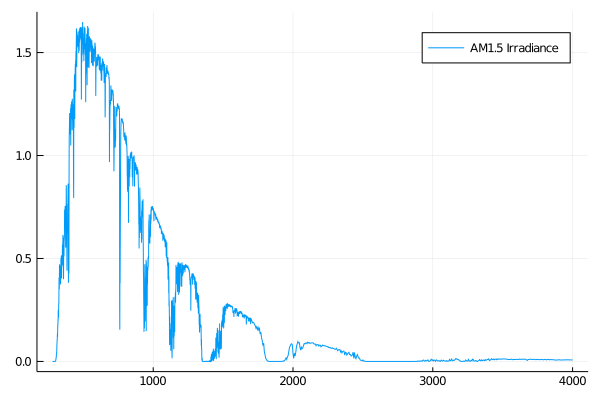

1000.3706555734398

In [9]:
am15 = readdlm("astmg173.csv", ',', Float64, '\n', skipstart=2);
λ = am15[:,1];
irrad = am15[:,3]; # irradiance (intensity) W /m^2 /nm

# interpolate
I=interpolate((λ,),irrad,Gridded(Linear()));
p=plot(λ, I(λ), label="AM1.5 Irradiance")
display(p)

# determine band gap energy range
Es = LinRange(1240/maximum(λ), 1240/minimum(λ), 1000)

# checking normalisation
Psolar = integrate(λ, I(λ))
print(Psolar)

# can filter data to be a certain range 
# plot(λ[λ.>1000], I(λ[λ.>1000]))

Since $E=\frac{hc}{\lambda}$, we can obtain the photon flux density. 

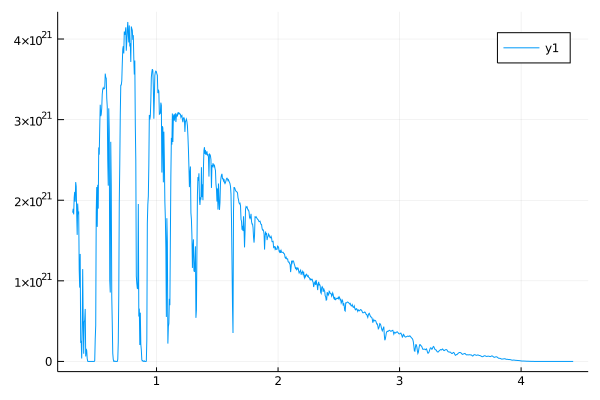

In [10]:
# h*c / eV = 1240 nm
λdB = 1240 ./ Es 
# photon flux per energy (also change units) # 1 / m^2 / eV / s
# [I] = W /m^2 /nm
# [Es] = eV
# [hc] = eV nm
γ = I(λdB) ./Es * 1240 ./ Es.^2 / eV #/ 1e9
# γ = W / m^2 /nm / eV * eV nm / eV^2 / eV
#   = W / m^2 / eV
display(plot(Es, γ))

The short-circuit current density is
$$
J_{\rm sc} = q\int_{E_g}^\infty {\rm d}Eb_s(E)Q_E(E) = q\int_{E_g}^\infty {\rm d}E\gamma(E)
$$
for an ideal cell. I used notation such that $\gamma=b_s$ (Jenny Nelson's notation).

We also have (TODO: explain origin)
$$
J_0 = q\frac{2F_a}{h^3c^2}\int_{E_g}^\infty {\rm d}E \frac{E^2}{e^{E/k_BT_{\rm cell}}-1}
$$
where $F_a=\pi$ in the ideal case (normal incidence of all rays). 

Finally, 
$$
J = J_{\rm sc} - J_0(e^{qV/k_BT}-1)
$$

In [11]:
# for a given band gap Eg, define the function Jsc
Jsc(Eg) = q*integrate(Es[Es.>=Eg], γ[Es.>=Eg]) # 0.1 converts A/m^2 to mA/cm^2
function J0(Eg) 
    E = Es[Es.>=Eg];
    integrand = q*2*π * eV / h^3 / c^2 * (E*eV).^2 ./ (exp.(E.*eV./kB./Tcell).-1);
    integrate(E, integrand)
    # C * eV / eV / nm / m^2 /kg *s * eV^2
    # C * nm / m^2 / kg * s * eV^2
end
# J0(1)
# Jsc(1)
J(Eg, V) = Jsc(Eg).-J0(Eg).*(exp.(q.*V./kB./Tcell).-1)
Voc(Eg) = kB*Tcell / q * log.(Jsc(Eg)./J0(Eg));

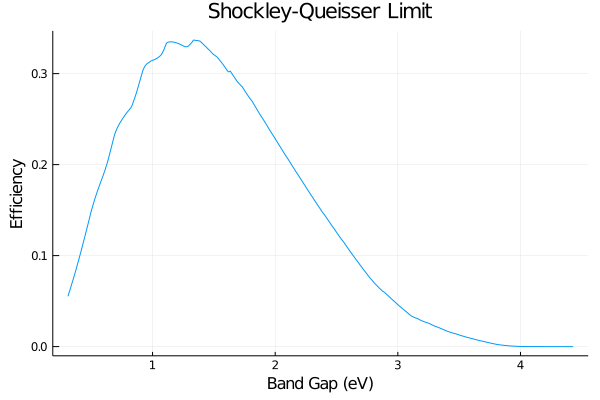

Maximum single-junction solar cell efficiency is 33.68865463105594% at 1.3365508365508365 eV band gap.


In [12]:
# V is from 0 to V_oc 
# for now just use 0 to E_g
η = zeros(size(Es))
for i in 1:length(Es)
    Eg = Es[i]
    Vs = LinRange(0, Eg, 1000)
    Jcurr = J(Eg,Vs)
    η[i] = maximum(Jcurr.*Vs/Psolar)
end
p = plot(Es, η, title="Shockley-Queisser Limit", xlabel="Band Gap (eV)", ylabel="Efficiency", leg=false)
display(p)
j = argmax(η)
println("Maximum single-junction solar cell efficiency is $(100*η[j])% at $(Es[j]) eV band gap.")

TODO compare with 6000 K (maybe 5800 K) black body

In [14]:
η_qs = interpolate((Es,),η,Gridded(Linear()));
println("Maximum single-junction c-Si solar cell efficiency is $(100*η_qs(1.12))% at 1.12 eV band gap.")
println("Maximum single-junction CdTe solar cell efficiency is $(100*η_qs(1.44))% at 1.44 eV band gap.")

0.3368864959264583